<a href="https://colab.research.google.com/github/dkanh6/Machine_Learning_Examples/blob/main/MiniProject2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Data and Extract it into useable data structure

In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson, expon

# Establish URL
url = 'https://raw.githubusercontent.com/dkanh6/Machine_Learning_Examples/main/Data/wine.data'
interval_len = 0.001


This function will load and preprocess the data

In [131]:
def load_and_preprocess(url):
  data = pd.read_csv(url,header=None, names=['SpikeTimes'])
  data['SpikeTimeSeconds'] = data['SpikeTimes'] / 20000 # signals being recorded at 20kHz so 20k per second

  # Drop rows with NaN values
  data = data.dropna()

  # reset index if rows are being dropped
  data.reset_index(drop=True, inplace=True)

  if data['SpikeTimeSeconds'].var() == 0:
    raise ValueError("Variance of spike times is zero, histogram cannot be computed.")

  if not np.isfinite(data['SpikeTimeSeconds']).all():
    raise ValueError("Data contains non-finite numbers.")

  return data

This function will analyze spikes inter spike time and plot a histogram

In [132]:
def calculate_spike_counts(data, interval_length):
    max_time = data['SpikeTimeSeconds'].max()
    bins = np.arange(0, max_time + interval_length, interval_length)
    spike_counts, bin_edges = np.histogram(data['SpikeTimeSeconds'], bins=bins)

    if np.any(np.diff(bin_edges) == 0):
        raise ValueError("One or more bins have zero width.")

    if spike_counts.sum() == 0:
        raise ValueError("Total count is zero, density cannot be computed.")

    return spike_counts, bin_edges

def plot_poisson_fit(spike_counts):
    # Calculate the mean spike count as the Poisson parameter (lambda)
    lambda_poisson = spike_counts.mean()

    # Generate the x-values (spike counts) for the Poisson PMF: from 0 to max spike count
    x_values = np.arange(0, spike_counts.max() + 1)

    # Calculate Poisson PMF values for each x-value
    poisson_pmf_values = poisson.pmf(x_values, lambda_poisson)

    # Plot the histogram of spike counts
    plt.figure(figsize=(10, 6))
    counts, bins, patches = plt.hist(spike_counts, range=(0, spike_counts.max()), bins=30, density=True, alpha=0.6, color='g', label='Spike Counts Histogram')

    # Plot the Poisson PMF
    plt.plot(x_values, poisson_pmf_values, 'r-', lw=2, label='Poisson PMF')

    plt.xlabel('Spike Count')
    plt.ylabel('Probability')
    plt.title('Spike Counts and Poisson Distribution Fit')
    plt.legend()
    plt.show()



Now analyze Inter-Spike Intervals byt defining functions to calculate the ISI and fit a distribution to it

In [133]:
def calculate_isi(data):
  isi = np.diff(np.sort(data['SpikeTimeSeconds'].values))
  return isi

def plot_exponential_fit(isi):
  lambda_exp = 1 / isi.mean()
  exp_pdf = expon.pdf(np.sort(isi), scale=1/lambda_exp)

  plt.figure(figsize=(10, 6))
  plt.hist(isi, bins=30, density=True, alpha=0.6, color='b', label='ISI Histogram')
  plt.plot(np.sort(isi), exp_pdf, 'r-', lw=2, label='Exponential PDF')
  plt.xlabel('Inter-Spike Interval (seconds)')
  plt.ylabel('Probability')
  plt.title('Inter-Spike Intervals and Exponential Distribution Fit')
  plt.legend()
  plt.show()

Finally, make a function that will integrate all the prior functions into a single pipeline function for easy analysis of all the data sets

In [134]:
def analyze_spike_data(url, interval_length=1):
  # Load and preprocess the data
  data = load_and_preprocess(url)

  #Calculate spike counts and plot Poisson fit
  spike_counts, bin_edges = calculate_spike_counts(data, interval_length)
  plot_poisson_fit(spike_counts)

  # Calculate ISI and plot exponential fit
  isi = calculate_isi(data)
  plot_exponential_fit(isi)

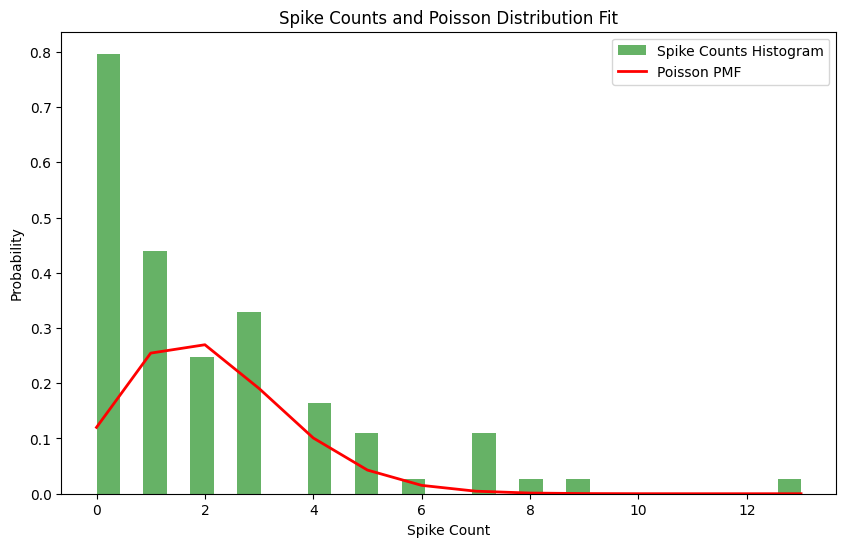

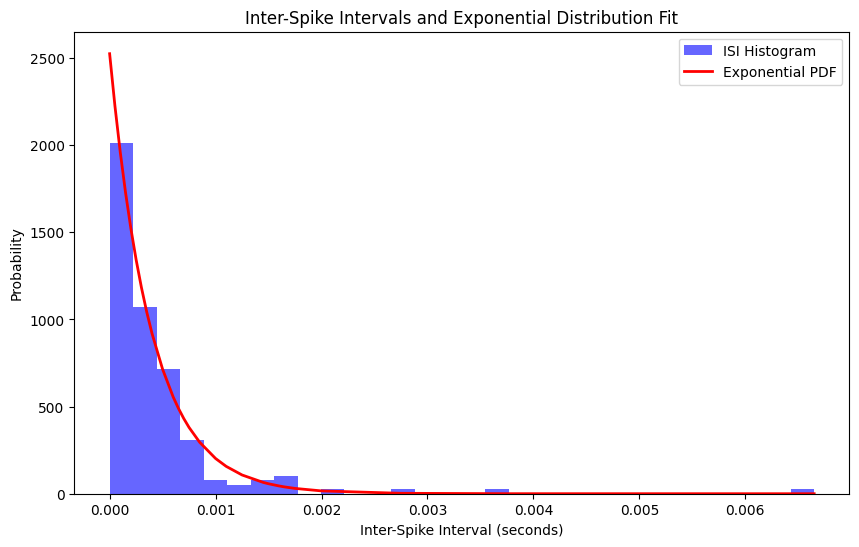

In [135]:
analyze_spike_data(url,interval_len)